In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import measure
from skimage.measure import regionprops_table
from skimage.draw import rectangle
import os
import pandas as pd


In [2]:
# get the current path of the Jupyter Notebook file
notebook_path = os.getcwd()
# bulid the path to the target folder
target_floder = os.path.join(notebook_path, 'images')
# change the working directory
os.chdir(target_floder)

# First task  
1.  Images contain only connecting rods, which can be of both types and feature significantly 
diverse dimensions. 
2. Connecting rods have been carefully placed within the inspection area so to appear well 
separated in images (i.e. they do not have any contact point).
3. Images have been taken by the backlighting technique so to render rods easily distinguishable 
(i.e. much darker) from background. However, for flexibility reasons the system should not 
require any change to work properly with lighting sources of different power.

In [3]:
images_task_1 = ["Tesi00.bmp", "Tesi01.bmp", "Tesi12.bmp", "Tesi21.bmp", "Tesi31.bmp", "Tesi33.bmp"]
task_1_images = [cv2.imread(image.upper()) for image in images_task_1]

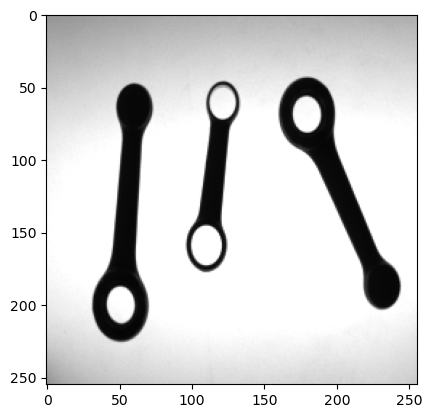

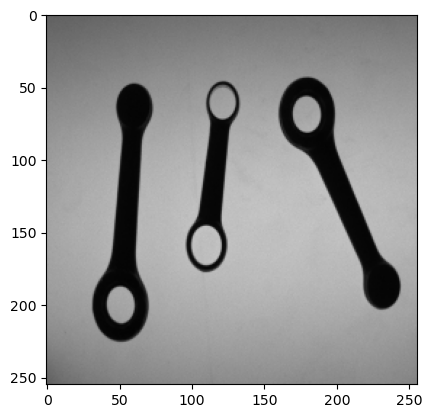

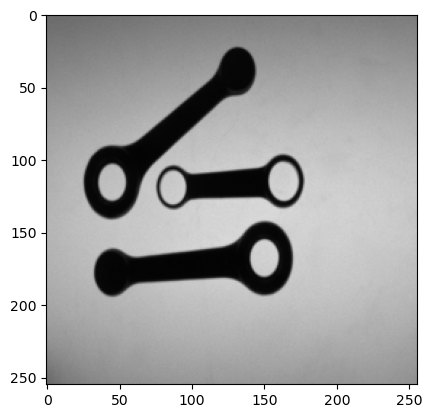

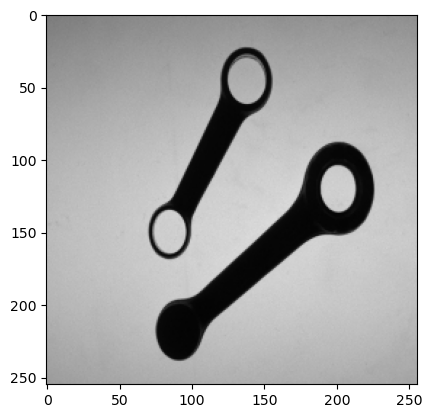

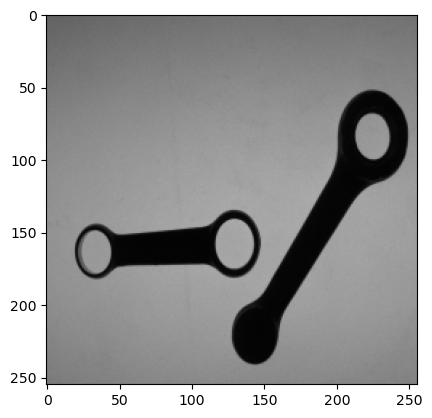

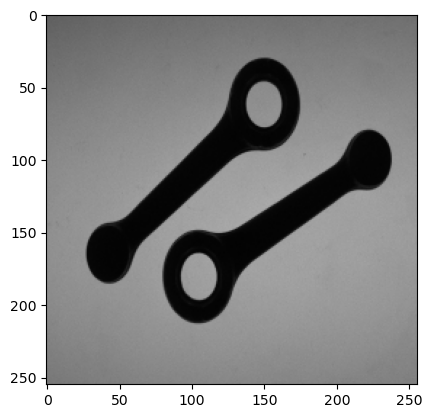

In [4]:
for image in task_1_images:
  plt.imshow(image)
  plt.show()

In [13]:
def width_at_barycenter(center, contour):
    distances = [np.linalg.norm(center - p[0]) for p in contour]
    min_distance = min(distances)
    width = min_distance * 2
    return width

In [14]:
def task_1(image):

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  #convert the input image to grayscale
    _, binarized_image = cv2.threshold(gray, 128, 256, cv2.THRESH_OTSU) #here we use Otsu to the binarize
    #binarized_image = cv2.Canny(image, 128,256)
    plt.imshow(binarized_image, cmap="gray")
    plt.show()
    
    inverted_binarized_image = cv2.bitwise_not(binarized_image) #get the image after invert, better for finding the contours
    plt.imshow(inverted_binarized_image, cmap="gray")
    plt.show()

    
    
    labels = measure.label(inverted_binarized_image) #label connected regions

    properties =['area',        #set the properties for each label of connected regions
                'centroid',
                'perimeter',
                'orientation',
                'bbox',
                'bbox_area',
                'label',
                "euler_number",
                "major_axis_length",
                "minor_axis_length"]
    
    df = pd.DataFrame(regionprops_table(labels, properties = properties))  #Creat a DataFrame containing region properties of the labeled regions

    labels_list = df["label"].to_list() #get the list of labels from the DataFrame
   
     # get to know the type of rods by the euler_number
    df["type"] = ["A" if x == 0 else "B" for x in df["euler_number"]]

    for i in range(0, len(labels_list)):
        
        print("Length is ",df["major_axis_length"].iloc[i])
        print("Width is ",df["minor_axis_length"].iloc[i])
        
        rod_image = np.where(labels == labels_list[i], 0, 255).astype(np.uint8)#extract the connected region into rod_image
        plt.subplot(1, 2, 1)
        plt.imshow(rod_image, cmap="gray") #show the gray scale images, seen as the left image
        plt.title(f"The centroid of Type {df.iloc[i]['type']} rod at {(int(df.iloc[i]['centroid-0']), int(df.iloc[i]['centroid-1']))}")
        # add the title for each image with the type and the coordinate of centroid
        
        
        
        #canny = cv2.Canny(rod_image, 100, 200)
        #find the contours in the binarized images
        contours, hierarchy  = cv2.findContours(rod_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        widthB = width_at_barycenter((int(df.loc[i, 'centroid-1']), int(df.loc[i, 'centroid-0'])), contours[1])
        print(f"The width of barycenter = {widthB}")
        
        circle_indices = [cnt for cnt in np.unique(hierarchy).tolist()[3:]]
        circles = np.zeros_like(inverted_binarized_image, dtype=np.uint8) #creat a binarized image with the same size of binarized_image
        
        for cnt in circle_indices:
            
            circle = np.zeros_like(inverted_binarized_image, dtype=np.uint8) #create circle as a whole black image at the size of ...
            cv2.drawContours(circle, contours, cnt, (255,255,255), 3) #draw the contours on circle
            circle_cnt, _ = cv2.findContours(circle, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) # save the contours in circle_cnt
          
            cv2.drawContours(circles, contours, cnt, (255,255,255), 3) #re-draw the circle showing as the hole, seen as the right image
            (x,y), _, _ = cv2.fitEllipse(circle_cnt[-1]) # save the centre coordinates of the ellipse
            # (x,y),major_axis_length,minor_axior_length
            area = cv2.contourArea(circle_cnt[-1])
            equi_diameter = np.sqrt(4*area / np.pi) # get the diameter size
            # this method followed the way of calcuting the area of a circle, otherwise use diameter=max(major_axis_length,minor_axior_length)
            if equi_diameter > 10:
                print('The hole point is at {} with diameter: {:.4f}.'.format((x,y), equi_diameter))
        plt.subplot(1, 2, 2)
        plt.imshow(circles, cmap="gray")
        plt.show()
        
        
        
        direction = df.loc[i, 'orientation'] # get the orientation at the connected region i 
        #print("The direction is ",direction)
        x1, y1 = int(df.loc[i, 'centroid-1']), int(df.loc[i, 'centroid-0']) #get the cooridinate of the centroid
        length = int(df.loc[i,'major_axis_length']/2)
        x2 = int(x1 + length * np.sin(direction))
        y2 = int(y1 + length * np.cos(direction))
        
        
        #draw the major axis
        inverted_binarized_image = cv2.line(inverted_binarized_image, (x1, y1), (x2, y2), (136,8,8), 1) 
        #draw the location of centorid
        inverted_binarized_image = cv2.circle(inverted_binarized_image, # draw the cerntre point on the connected region
                      (int(df.loc[i, 'centroid-1']), int(df.loc[i, 'centroid-0'])), 
                      4,
                      (136, 8, 8), -1)
        #draw the bounding box
        inverted_binarized_image = cv2.rectangle(inverted_binarized_image, # draw the bounding box
                      (df.loc[i, "bbox-1"], df.loc[i, "bbox-0"]), 
                      (df.loc[i, "bbox-3"], df.loc[i, "bbox-2"]),
                      (255), 2)

    plt.imshow(inverted_binarized_image)
    plt.show()



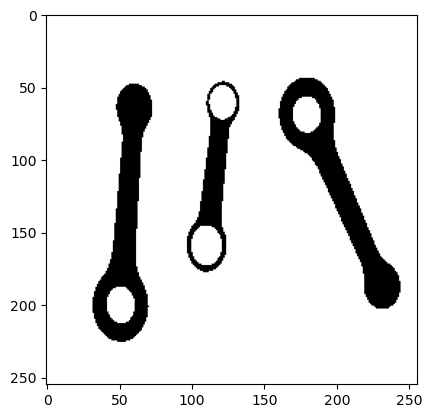

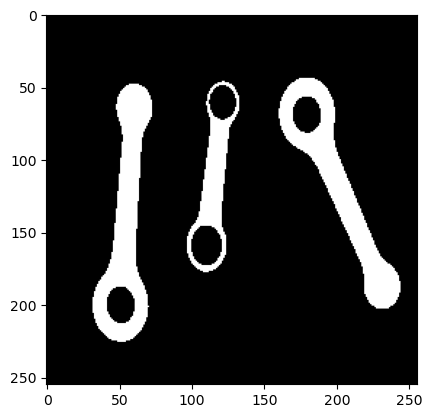

Length is  205.1514042754788
Width is  32.053060695961975
The width of barycenter = 16.1245154965971
The hole point is at (179.02549743652344, 68.86041259765625) with diameter: 17.4078.


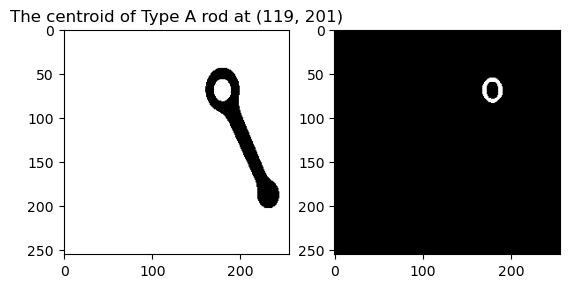

Length is  133.55211702930862
Width is  23.6939112310361
The width of barycenter = 14.142135623730951
The hole point is at (109.94184112548828, 158.96884155273438) with diameter: 19.4788.
The hole point is at (121.15300750732422, 60.31775665283203) with diameter: 16.0967.


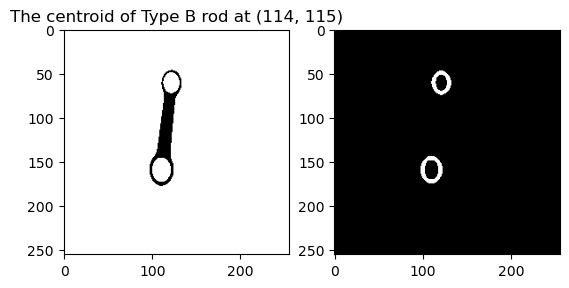

Length is  216.58677483811175
Width is  30.39738227646115
The width of barycenter = 14.560219778561036
The hole point is at (50.980831146240234, 199.93646240234375) with diameter: 17.4078.


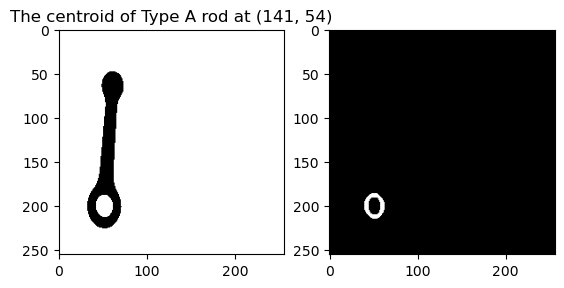

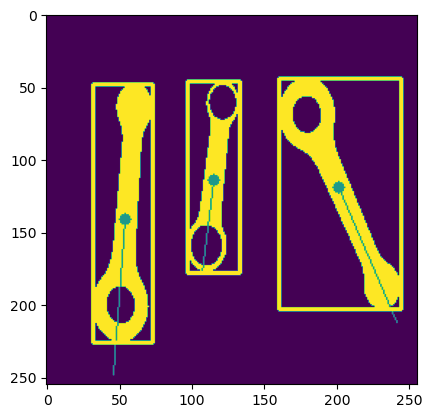

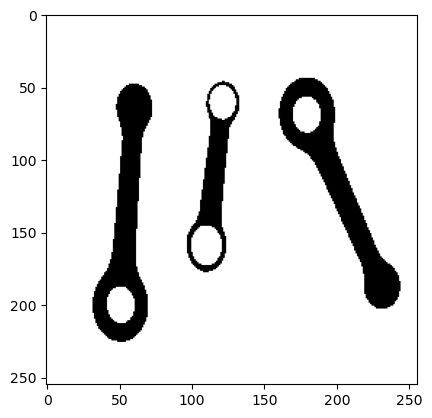

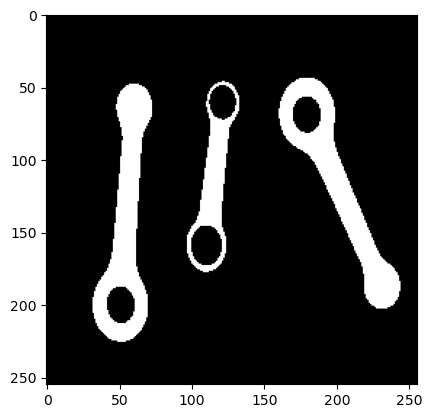

Length is  205.00912771902483
Width is  32.0900703422814
The width of barycenter = 16.1245154965971
The hole point is at (178.99819946289062, 68.83365631103516) with diameter: 17.3712.


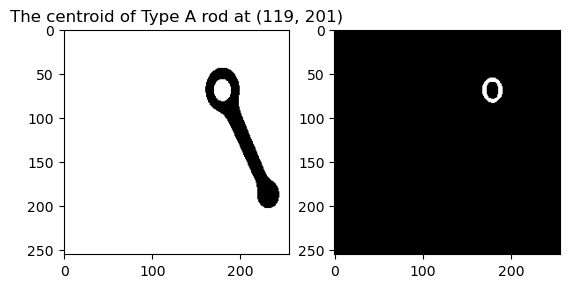

Length is  133.50561031172288
Width is  23.696907830332663
The width of barycenter = 14.142135623730951
The hole point is at (109.91658020019531, 158.95008850097656) with diameter: 19.5115.
The hole point is at (121.09754943847656, 60.199989318847656) with diameter: 16.0769.


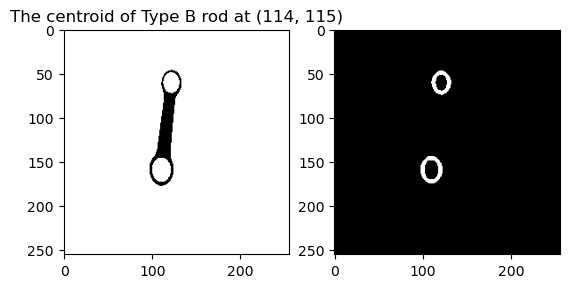

Length is  216.50318589031139
Width is  30.375585194213468
The width of barycenter = 14.560219778561036
The hole point is at (51.00823211669922, 199.914794921875) with diameter: 17.3712.


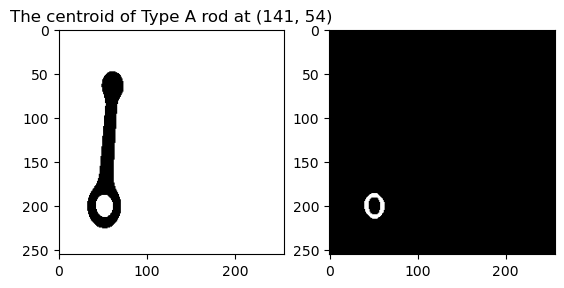

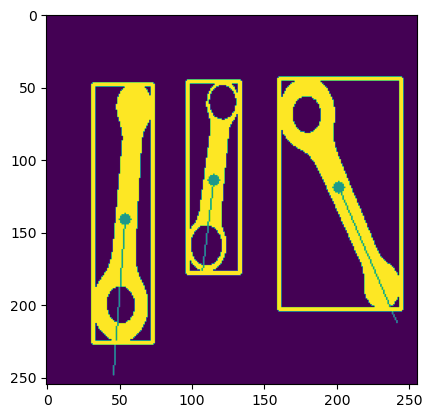

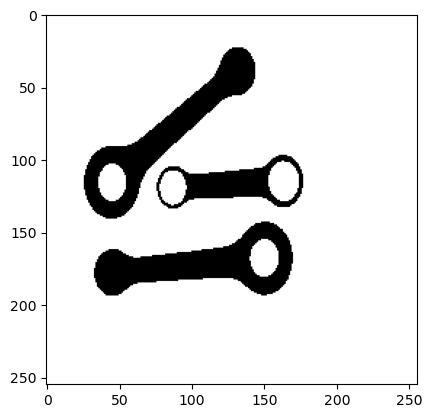

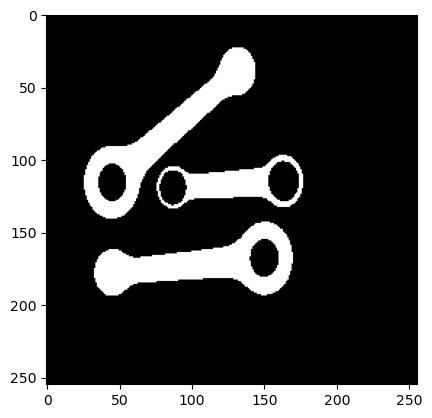

Length is  183.23465775069928
Width is  35.82799319320532
The width of barycenter = 17.88854381999832
The hole point is at (45.07568359375, 115.55414581298828) with diameter: 17.5716.


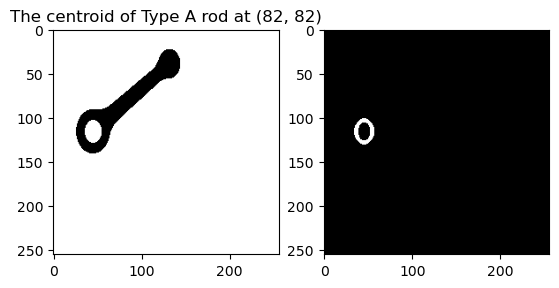

Length is  101.70322987277201
Width is  30.926847304345415
The width of barycenter = 19.697715603592208
The hole point is at (86.90291595458984, 119.12391662597656) with diameter: 16.1559.
The hole point is at (163.07754516601562, 114.66410827636719) with diameter: 19.5115.


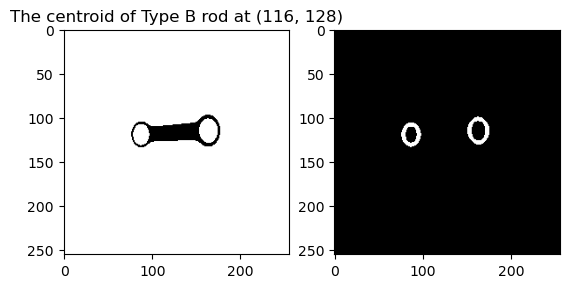

Length is  166.30661105863066
Width is  39.72403359657865
The width of barycenter = 20.396078054371138
The hole point is at (149.80245971679688, 167.5447540283203) with diameter: 17.9834.


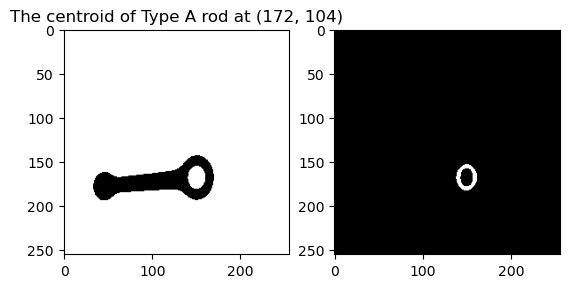

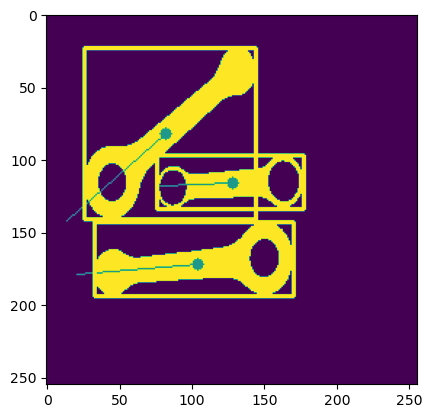

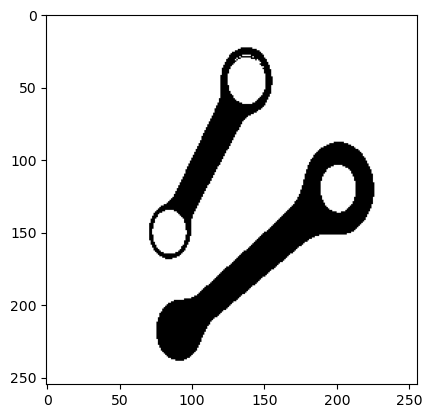

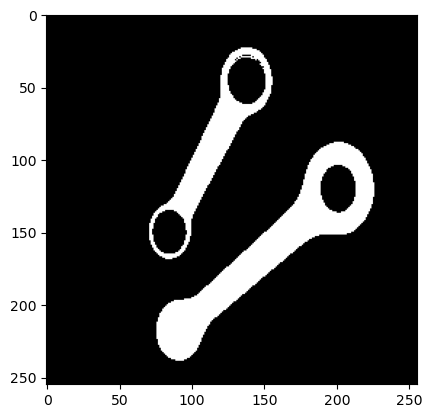

Length is  159.99015949211827
Width is  32.66028402011603
The width of barycenter = 18.867962264113206
The hole point is at (84.43095397949219, 149.63575744628906) with diameter: 21.8364.
The hole point is at (137.62933349609375, 45.39472579956055) with diameter: 24.3975.


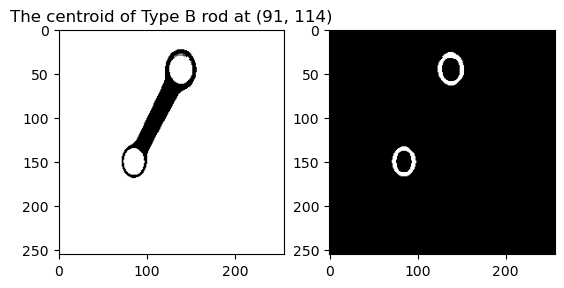

Length is  232.86811135246492
Width is  45.5092120148527
The width of barycenter = 24.08318915758459
The hole point is at (200.56185913085938, 119.82695770263672) with diameter: 23.4800.


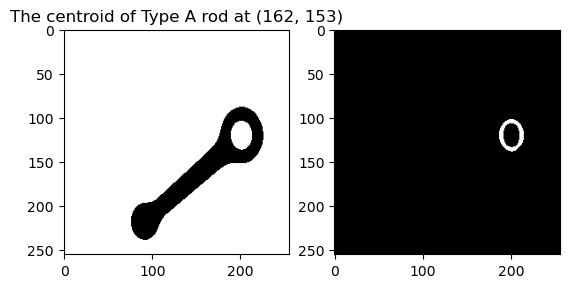

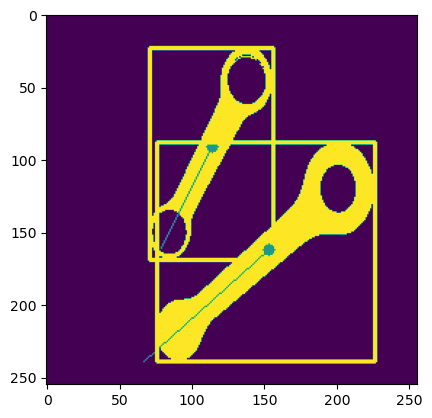

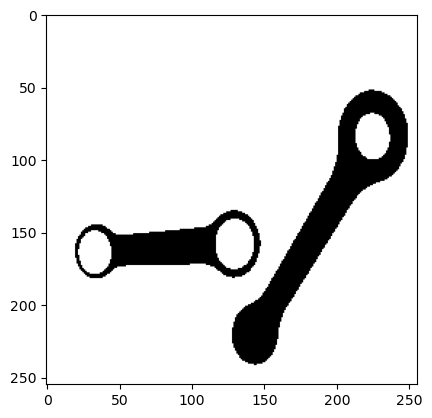

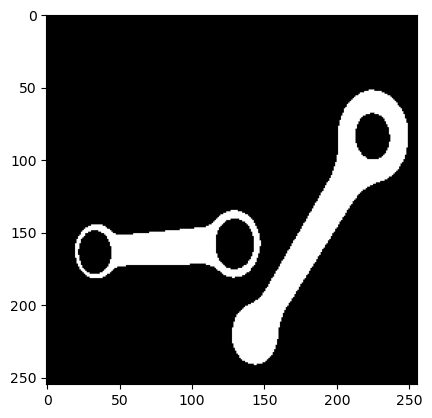

Length is  251.68645675971595
Width is  41.74223019390991
The width of barycenter = 19.697715603592208
The hole point is at (224.30567932128906, 83.87869262695312) with diameter: 22.8479.


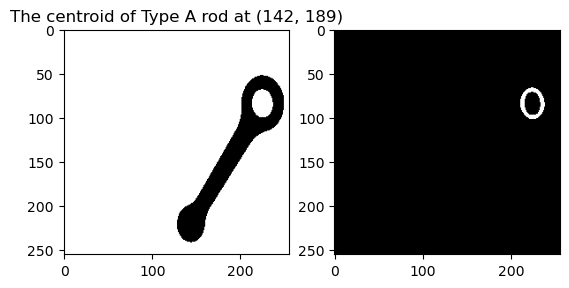

Length is  129.76583130562972
Width is  39.645919571968975
The width of barycenter = 24.166091947189145
The hole point is at (33.198448181152344, 163.72738647460938) with diameter: 21.4095.
The hole point is at (129.365478515625, 157.93507385253906) with diameter: 25.8175.


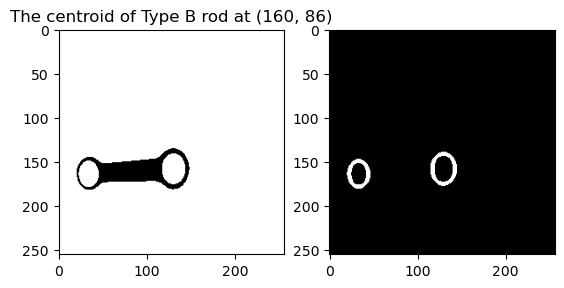

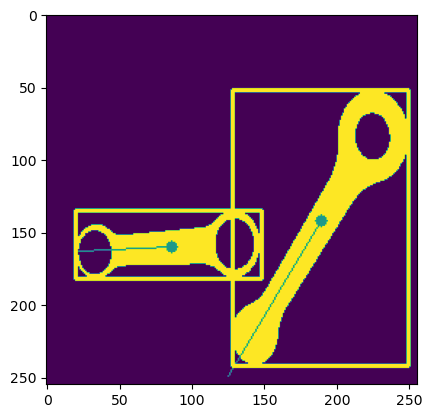

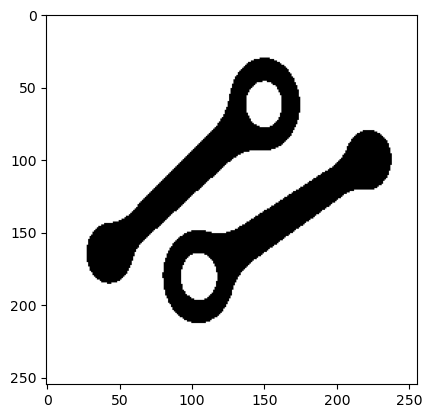

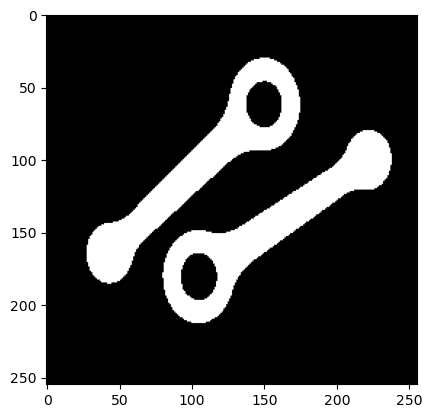

Length is  234.4391771974217
Width is  45.18528993858408
The width of barycenter = 25.612496949731394
The hole point is at (149.55836486816406, 61.705074310302734) with diameter: 23.3031.


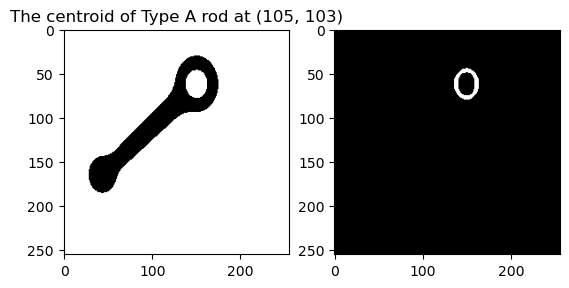

Length is  225.18998289404277
Width is  47.20566911309183
The width of barycenter = 21.633307652783937
The hole point is at (104.79667663574219, 180.4480743408203) with diameter: 23.7630.


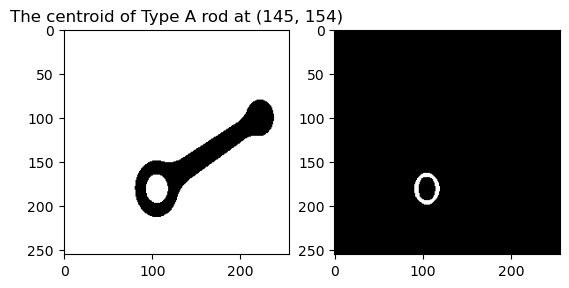

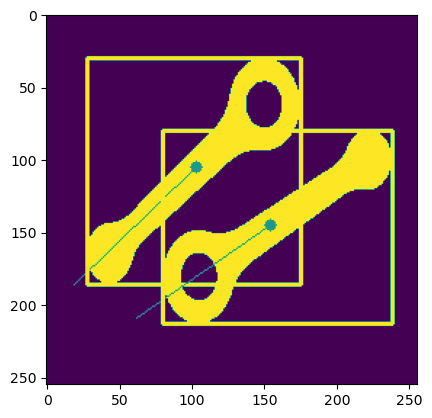

[None, None, None, None, None, None]

In [15]:
[task_1(image) for image in task_1_images]

# Second task

2.1 Filtering distractors:  
Images may contain other objects (i.e. screws and washers) that need not to be analysed by the system (such kind of objects are often referred to in computer vision as “distractors”). 

For implementing this function, I filtering distractors by comparing the area, for distractors under a certain value of area then it will be filtered, cause from the images, the distrators are basically smaller than the rods.


In [16]:
images_task_2_1= [ "Tesi44.bmp", 
                   "Tesi47.bmp", 
                  "Tesi48.bmp", 
                  "Tesi49.bmp"
                  ]
task_2_1_images = [cv2.imread(x.upper()) for x in images_task_2_1]

In [17]:
def task_2_1(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert the input image to grayscale
    _, binarized_image = cv2.threshold(gray, 128, 256, cv2.THRESH_OTSU) #here we use Otsu to the binarize   
    inverted_binarized_image = cv2.bitwise_not(binarized_image)  #get the image after inverted


    
    labels = measure.label(inverted_binarized_image)
    properties =['area',
                'centroid',
                'perimeter',
                'orientation',
                'bbox',
                'bbox_area',
                'label',
                "euler_number",
                "major_axis_length",
                "minor_axis_length"]
  
    df = pd.DataFrame(regionprops_table(labels, properties = properties))  
    
    
    df = df[df["area"] >= 1100]  #filter the distractors by considering the area of the connected region

    labels_list = df["label"].to_list()
    
    df["type"] = ["A" if x == 0 else "B" for x in df["euler_number"]]


    for i in range(0, len(labels_list)):
        
        print("Length is ",df["major_axis_length"].iloc[i])
        print("Width is ",df["minor_axis_length"].iloc[i])
        
        rod_image = np.where(labels == labels_list[i], 0, 255).astype(np.uint8)#creat a binarized image to save
        plt.subplot(1, 2, 1)
        plt.imshow(rod_image, cmap="gray")
        plt.title(f"The centroid of Type {df.iloc[i]['type']} rod at {(int(df.iloc[i]['centroid-0']), int(df.iloc[i]['centroid-1']))}")
 


        contours, hierarchy  = cv2.findContours(rod_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        widthB = width_at_barycenter((int(df.iloc[i]['centroid-1']), int(df.iloc[i]['centroid-0'])), contours[1])
        print(f"The width of barycenter = {widthB}")
        circle_indices = [cnt for cnt in np.unique(hierarchy).tolist()[3:]]       
        circles = np.zeros_like(inverted_binarized_image, dtype=np.uint8)
        
        for cnt in circle_indices:            
            circle = np.zeros_like(inverted_binarized_image, dtype=np.uint8)
            cv2.drawContours(circle, contours, cnt, (255,255,255), 3)
            circle_cnt, _ = cv2.findContours(circle, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

            cv2.drawContours(circles, contours, cnt, (255,255,255), 2)

            (x,y), _, _ = cv2.fitEllipse(circle_cnt[-1])
            area = cv2.contourArea(circle_cnt[-1])
            equi_diameter = np.sqrt(4*area/np.pi)
            if equi_diameter >10 and equi_diameter < 50:
                print('The hole point is at {} with diameter: {:.4f}.'.format((x,y), equi_diameter))
        plt.subplot(1, 2, 2)
        plt.imshow(circles, cmap="gray")
        plt.show()

        
        
        direction = df.iloc[i]['orientation'] 
        x1, y1 = int(df.iloc[i]['centroid-1']), int(df.iloc[i]['centroid-0'])
        length = int(df.iloc[i]['major_axis_length']/2)
        x2 = int(x1 + length * np.sin(direction))
        y2 = int(y1 + length * np.cos(direction))
        

        #draw the major axis
        inverted_binarized_image = cv2.line(inverted_binarized_image, (x1, y1), (x2, y2), (136,8,8), 1) 
        
        inverted_binarized_image = cv2.circle(inverted_binarized_image,
                      (int(df.iloc[i]['centroid-1']), int(df.iloc[i]['centroid-0'])), 
                      4,
                      (136, 8, 8), -1)
        inverted_binarized_image = cv2.rectangle(inverted_binarized_image,
                      (df.iloc[i]["bbox-1"], df.iloc[i]["bbox-0"]), 
                      (df.iloc[i]["bbox-3"], df.iloc[i]["bbox-2"]),
                      (255), 1)
        
    plt.imshow(inverted_binarized_image)
    plt.show()



Length is  219.57817580951397
Width is  45.43495661102986
The width of barycenter = 22.80350850198276
The hole point is at (211.67230224609375, 201.2001495361328) with diameter: 21.9672.


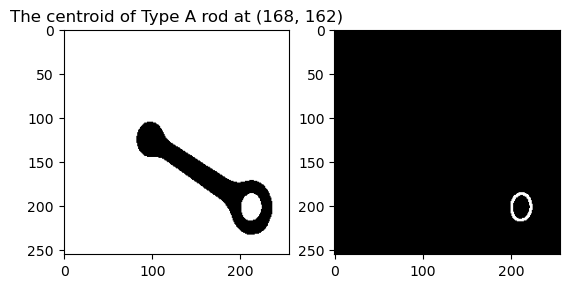

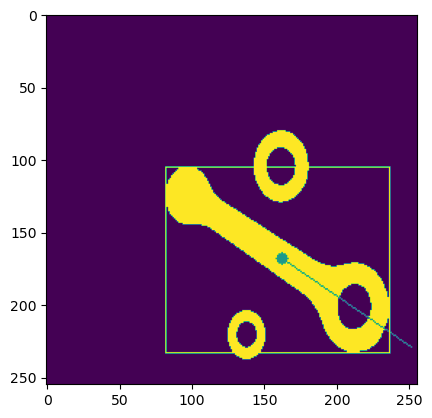

Length is  231.851055961018
Width is  43.007681479656995
The width of barycenter = 22.360679774997898
The hole point is at (208.3706817626953, 202.94436645507812) with diameter: 21.9672.


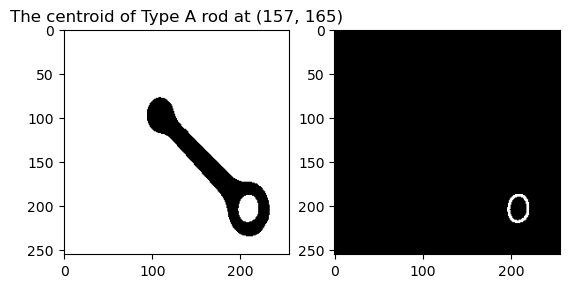

Length is  130.96010412339504
Width is  37.38869927250994
The width of barycenter = 20.591260281974
The hole point is at (132.6442413330078, 198.2071075439453) with diameter: 21.2453.
The hole point is at (44.04100799560547, 156.81295776367188) with diameter: 24.2929.


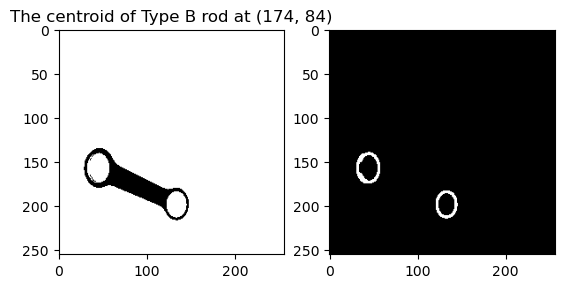

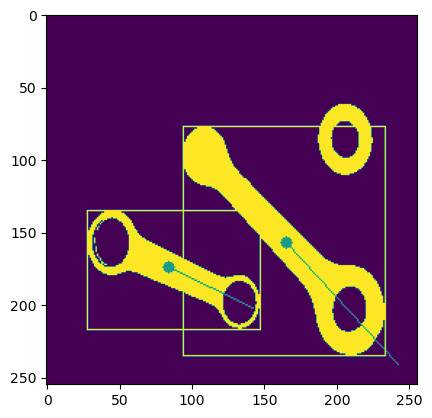

Length is  231.37813477716156
Width is  43.122688020955735
The width of barycenter = 22.80350850198276
The hole point is at (207.78233337402344, 212.0264129638672) with diameter: 21.9382.


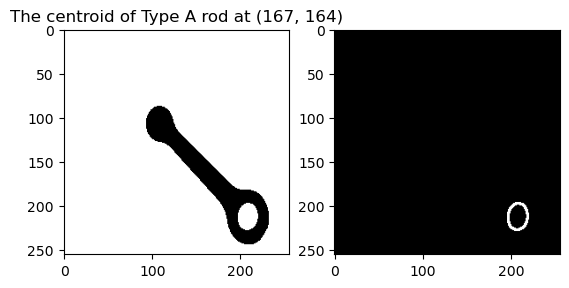

Length is  131.460761253257
Width is  37.37270423111108
The width of barycenter = 20.591260281974
The hole point is at (132.5648651123047, 198.2546844482422) with diameter: 21.2303.
The hole point is at (44.082176208496094, 156.6805419921875) with diameter: 24.2273.


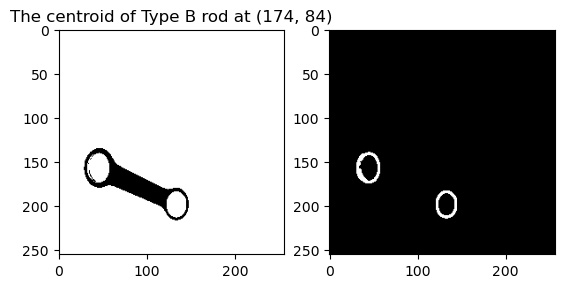

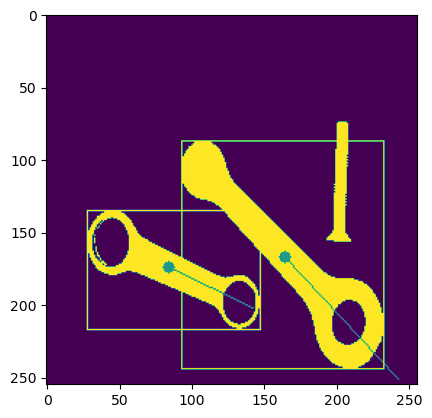

Length is  130.68882803865486
Width is  37.66241233898037
The width of barycenter = 22.360679774997898
The hole point is at (133.5, 195.43968200683594) with diameter: 21.3201.
The hole point is at (43.96562957763672, 157.6092987060547) with diameter: 24.2142.


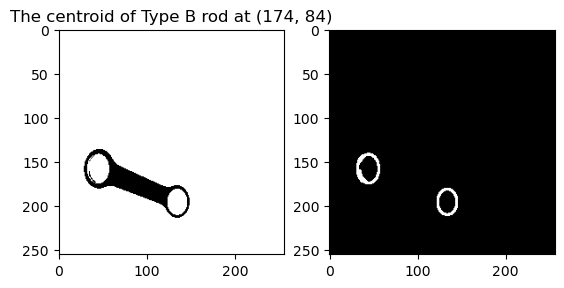

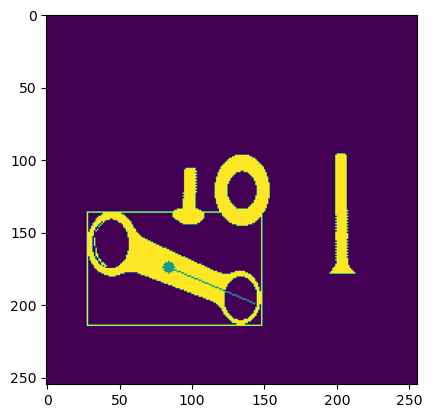

In [18]:
for img in task_2_1_images:
    task_2_1(img)
#[task_2_1(image) for image in task_2_1_images]